# Setup

In [1]:
# Colab setup
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'LLM-Project')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


In [8]:
from huggingface_hub import login

login()

# Nuscenes

In [2]:
import os
from PIL import Image

nuscenes_path = 'DriveLM/data/nuscenes/samples/'

nuscenes = {}

for folder in os.listdir(nuscenes_path):
    folder_path = os.path.join(nuscenes_path, folder)
    if os.path.isdir(folder_path):
        nuscenes[folder] = {}
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            nuscenes[folder][img_name] = Image.open(img_path)


# DriveLM

In [19]:
import json
from datasets import Dataset


class DriveLM:
    def __init__(self, json_path="DriveLM/data/QA_dataset_nus/v1_0_train_nus.json"):

        with open(json_path, 'r') as f:
            data = json.load(f)

        examples = []
        for scene_token, scene_data in data.items():
            scene_desc = scene_data.get('scene_description')
            for frame_token, frame_data in scene_data['key_frames'].items():
                image_paths = frame_data.get('image_paths', {})
                for task, qa_list in frame_data['QA'].items():
                    for qa in qa_list:
                        example = {
                            "scene_token": scene_token,
                            "frame_token": frame_token,
                            "scene_description": scene_desc,
                            "task": task,
                            "question": qa.get("Q"),
                            "answer": qa.get("A"),
                            "context": qa.get("C"),
                            "image_paths": image_paths,
                        }
                        examples.append(example)

        self.hf_dataset = Dataset.from_list(examples)

    def filter(self, function):
        self.hf_dataset = self.hf_dataset.filter(function)


    def __getitem__(self, idx):
      sample = self.hf_dataset[idx]
      return sample

    def __len__(self):
        return len(self.hf_dataset)

    def to_hugging_face(self):
        return self.hf_dataset


dataset = DriveLM()

In [20]:
import re


def contains_object(text):
    return re.search(r'<*>',text) != None

dataset.filter(lambda example: not contains_object(example['question']) and not contains_object(example['answer']))

len(dataset)

Filter:   0%|          | 0/377983 [00:00<?, ? examples/s]

132923

# Prepare for pushing

In [22]:
drivelm = dataset.to_hugging_face()

dict_dataset = {
    'CAM_FRONT_LEFT': [],
    'CAM_FRONT': [],
    'CAM_FRONT_RIGHT': [],
    'CAM_BACK_LEFT': [],
    'CAM_BACK': [],
    'CAM_BACK_RIGHT': []
}

path_to_index = {}
nuscenes_indexes = []

index = 0
for i in range(len(drivelm)):
    added = False
    for camera, path in drivelm[i]['image_paths'].items():
        if path in path_to_index:
             nuscenes_index = path_to_index[path]
        else:
            image_name = path.split('/')[-1]
            dict_dataset[camera].append(nuscenes[camera][image_name])
            nuscenes_index = index
            path_to_index[path] = index
            added = True
    if added:
        index += 1
    nuscenes_indexes.append(nuscenes_index)


In [23]:
drivelm = drivelm.add_column("nuscenes_index", nuscenes_indexes)

Flattening the indices:   0%|          | 0/132923 [00:00<?, ? examples/s]

In [43]:
drivelm_pushed = drivelm.remove_columns(["image_paths", "context"])

# Push to Hugging Face

In [32]:
from datasets import Dataset

hf_dataset = Dataset.from_dict(dict_dataset)

In [37]:
hf_dataset.push_to_hub("MehdiJmlkh/nuscenes")

Uploading the dataset shards:   0%|          | 0/7 [00:00<?, ? shards/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Map:   0%|          | 0/581 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Map:   0%|          | 0/581 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/499 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/MehdiJmlkh/nuscenes/commit/490bec4d87f56337c20371ceb589c1a4d8ca4172', commit_message='Upload dataset', commit_description='', oid='490bec4d87f56337c20371ceb589c1a4d8ca4172', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MehdiJmlkh/nuscenes', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MehdiJmlkh/nuscenes'), pr_revision=None, pr_num=None)

In [44]:
drivelm_pushed.push_to_hub("MehdiJmlkh/DriveLM")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/133 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/MehdiJmlkh/DriveLM/commit/e1edd96439de6b4887f89ff46f16bfdbc4251400', commit_message='Upload dataset', commit_description='', oid='e1edd96439de6b4887f89ff46f16bfdbc4251400', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MehdiJmlkh/DriveLM', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MehdiJmlkh/DriveLM'), pr_revision=None, pr_num=None)

# Test

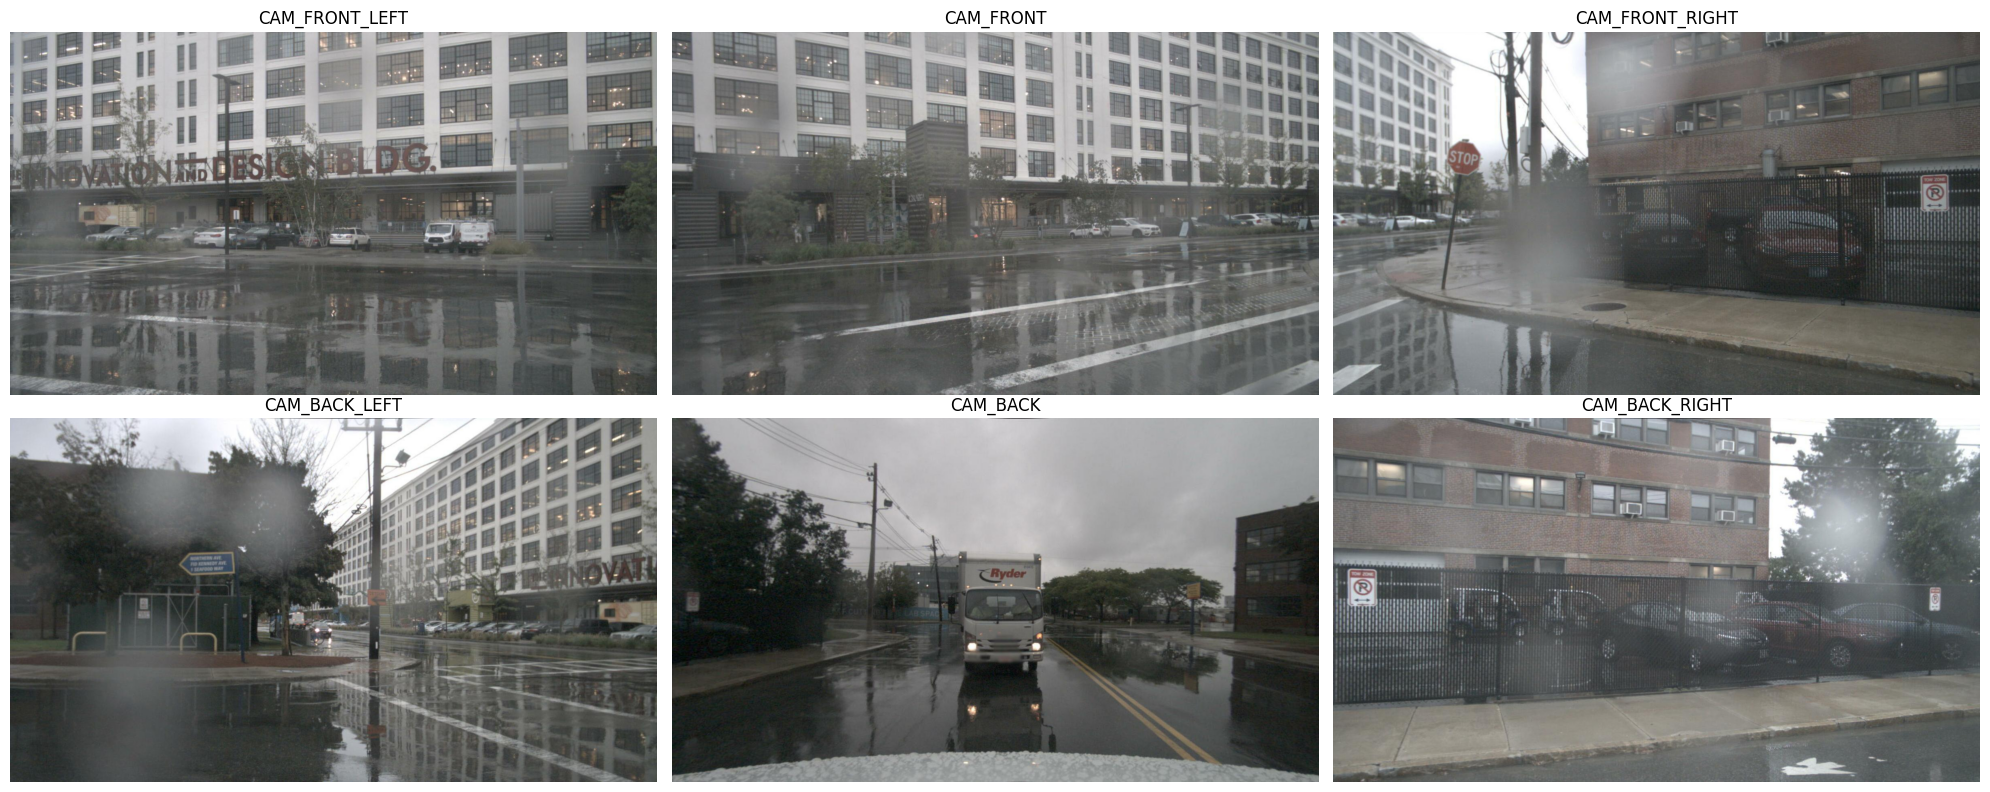

In [41]:
import matplotlib.pyplot as plt

index = 1010
sample = drivelm[index]

sample['images'] = {}
for image_type, image_path in sample['image_paths'].items():
      image_name = image_path.split('/')[-1]
      sample['images'][image_type] = nuscenes[image_type][image_name]

def display_image(image, title):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

plt.figure(figsize=(20, 8))
cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
for i, camera in enumerate(cameras):
    plt.subplot(2, 3, i + 1)
    display_image(sample['images'][camera], camera)
plt.tight_layout()
plt.show()

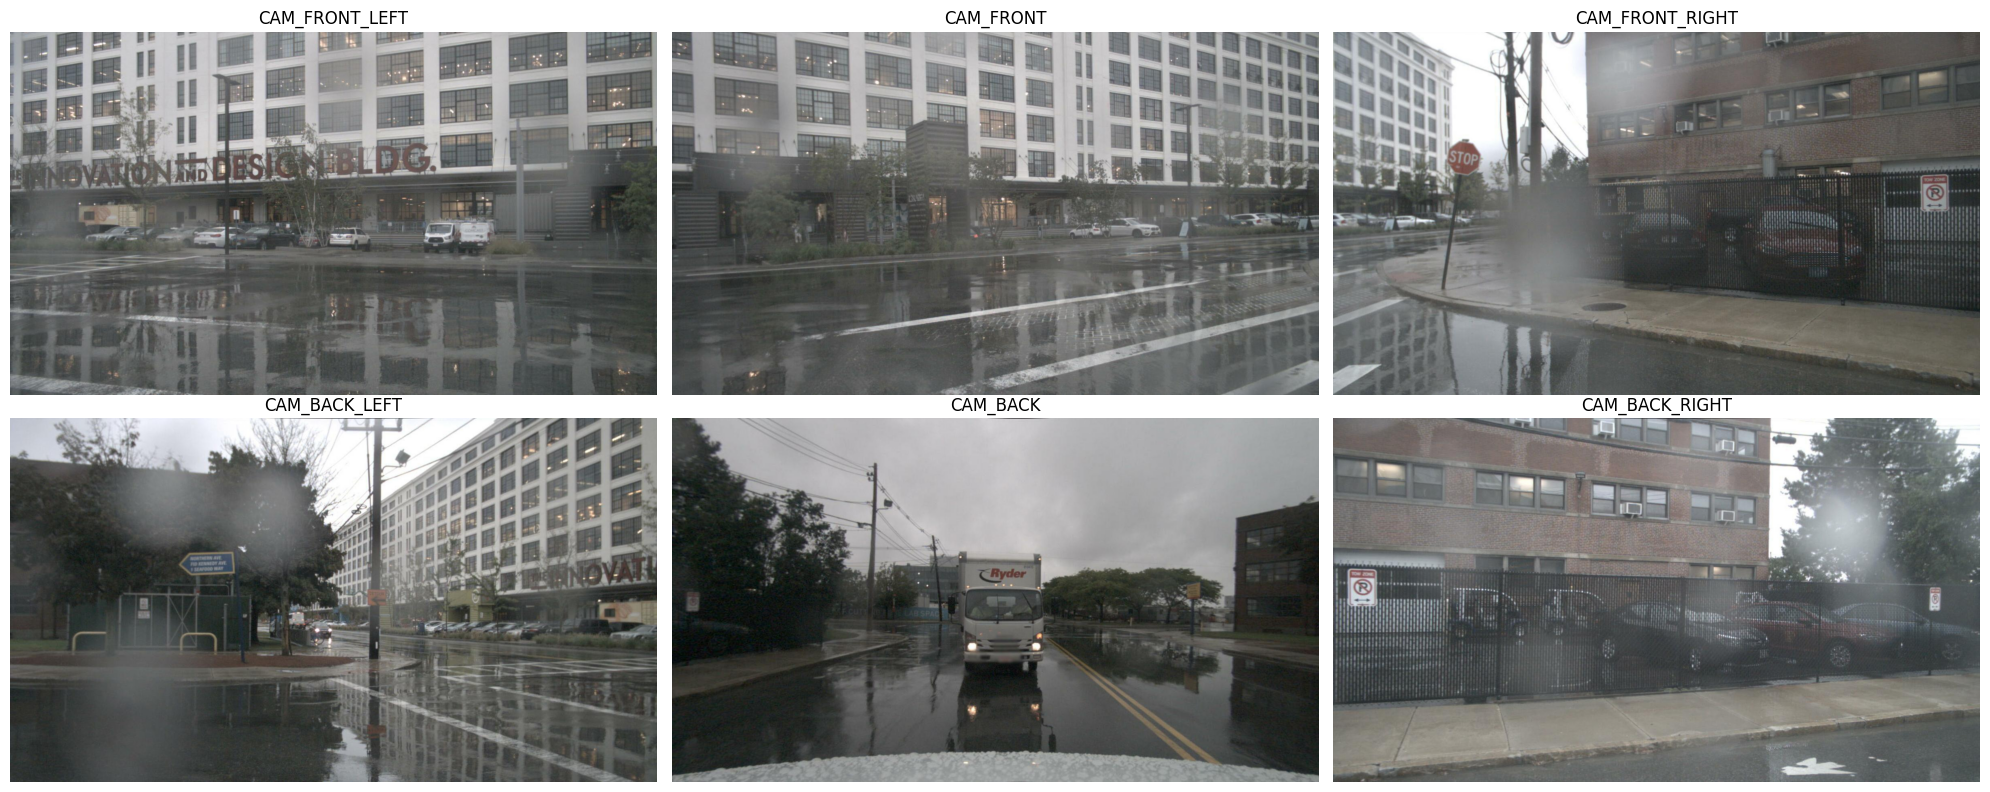

In [42]:
plt.figure(figsize=(20, 8))
for i, camera in enumerate(cameras):
    plt.subplot(2, 3, i + 1)
    nuscenes_index = sample["nuscenes_index"]
    display_image(hf_dataset[nuscenes_index][camera], camera)
plt.tight_layout()
plt.show()